In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import simulation_utils as su
import importlib

In [3]:
data = sio.loadmat(filename+'/Noise/PSD.mat')

In [6]:
data['J'][0]

array([3.91440813e-29, 1.92701156e-28, 2.39907380e-28, ...,
       9.38985040e-29, 9.77896391e-29, 5.14476379e-29])

1


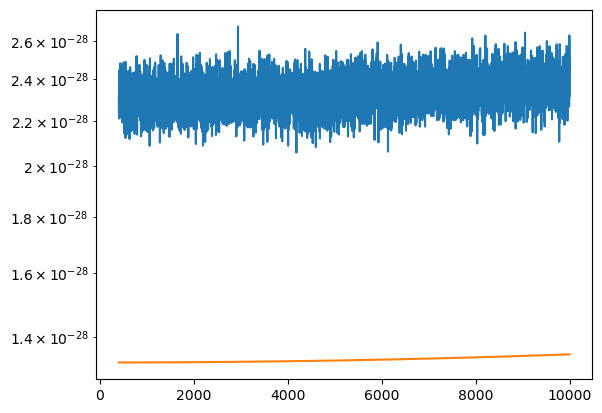

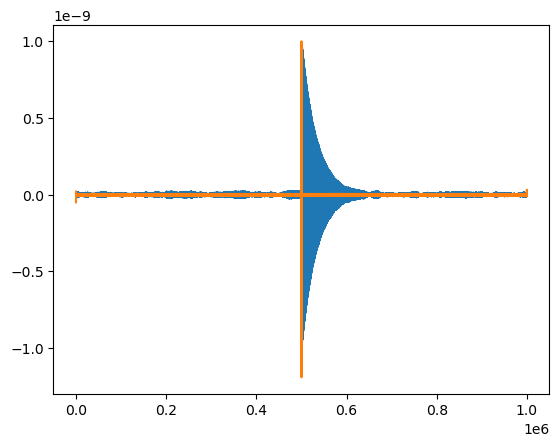

In [65]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240930/'

yfb_l = np.array([10])*2*np.pi
iter_l = [0.02]
for yfb in yfb_l:
    for iter in iter_l:

        numbins = int(2*5*10**4*100*2*np.pi/yfb)

        filename = 'D:/Simulation Data/240930/yfb' + str(round(yfb/2/np.pi))

        data = sio.loadmat(filename+'/Noise/PSD.mat')
        PSD_freq = data['frequency'][0]
        PSD_noise = data['J'][0]

        data = sio.loadmat(filename+'/Kicks/avr_resp.mat')
        avr_resp = data['x'][0]

        lb = 400
        ub = 10000
        plt.figure()
        plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
        plt.plot(PSD_freq[lb:ub], au.Linewidth2(np.array(PSD_freq[lb:ub]), 0.3*10**(-12), 55000, 1000, 10**(-28)))
        plt.yscale('log')

        plt.figure()
        plt.plot(avr_resp)

        phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

        plt.plot(phi_t*10**(-9))

        corr_max = []
        #corr_arg = []
        #corr_data_l = np.zeros((1000, numbins))
        for i in range(1000):
            data = sio.loadmat(filename+'/Kicks/' + str(i) +'.mat')
            x = data['x'][0]
            cm = au.optimal_filter(phi_t, x)
            corr_max.append(cm)
        print(1)
        
        corr_max_n = []
        #corr_data_l_n = np.zeros((1000, numbins))
        np.random.seed(3716)
        for i in range(1000):
            data = sio.loadmat(filename+'/Noise/' + str(i) +'.mat')
            x = data['x'][0]
            cm = au.optimal_filter_noise(phi_t, x)
            corr_max_n.append(cm)
        """
        print(2)
        cf = 55000
        BW = 30000
        amp_max = []
        for i in range(1000):
            max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max.append(max)
        
        print(3)
        
        amp_max_n = []
        for i in range(1000):
            max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max_n.append(max)

        print(4)
        
        analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
        au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)
        """

In [182]:
def exp_ft(w, w0, y):
    return 1/(w**2-w0**2-1j*w*y)

expected = exp_ft(np.linspace(0, 500000, 251), 80000, 10)

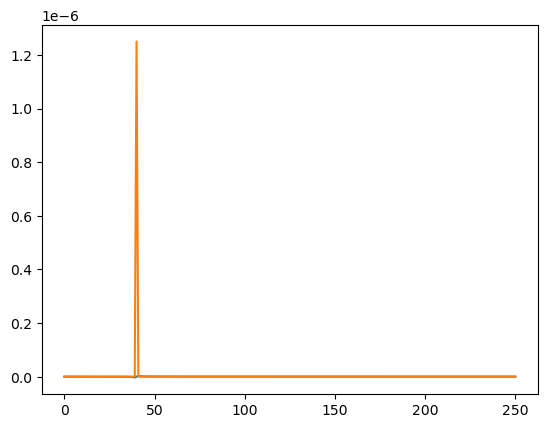

In [183]:
plt.plot(np.real(expected))
plt.plot(np.imag(expected))

In [352]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240930/'

yfb_l = np.array([10])*2*np.pi
iter_l = [0.02]
imp_lens = [2, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 151, 201]
for imp_len in imp_lens:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = 500#int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240930/implen' + str(imp_len) + '/yfb' + str(round(yfb/2/np.pi))

            force_rec = []
            for i in range(1000):
                data = sio.loadmat(filename+'/Kicks/' + str(i) +'.mat')
                x_f = au.butter_bandpass_filter(data['x'][0], 65000, 95000, fs = 10**6, order=3)
                #x_f = data['x'][0]
                kick_fft = np.fft.rfft(x_f)
                fr = np.fft.irfft(kick_fft/expected)
                force_rec.append(np.max(abs(fr[200:-200])))
            print(1)

            force_rec_n = []
            np.random.seed(3716)
            for i in range(1000):
                data = sio.loadmat(filename+'/Noise/' + str(i) +'.mat')
                x_f = au.butter_bandpass_filter(data['x'][0], 65000, 95000, fs = 10**6, order=3)
                #x_f = data['x'][0]
                kick_fft = np.fft.rfft(x_f)
                fr = np.fft.irfft(kick_fft/expected)
                m = int(np.random.uniform(0, 100))
                force_rec_n.append(fr[200+m])

            analysis_dict = {'Kicks': force_rec, 'Kicks noise': force_rec_n}
            au.save_data_hdf5(filename + '/analysis' + str(imp_len) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1
1
1
1


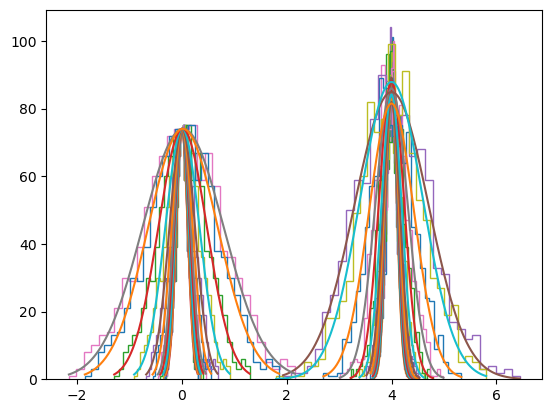

In [353]:
importlib.reload(au)

widths = []
widths_noise = []

for imp_len in imp_lens:
    filename = 'D:/Simulation Data/240930/implen' + str(imp_len) + '/yfb' + str(round(yfb/2/np.pi))
    analysis_dict = au.load_data_hdf5(filename + '/analysis' + str(imp_len) +'.hdf5')
    force_rec = analysis_dict['Kicks']
    force_rec_n  = analysis_dict['Kicks noise']
    hist3, bins3, fit3, x_hist3, fitted3 = au.histogram_and_fit(force_rec, 30, 5, fit = True, plot = False)
    hist4, bins4, fit4, x_hist4, fitted4 = au.histogram_and_fit(force_rec_n, 30, 5, fit = True, plot = False)

    plt.stairs(hist3, bins3*4/fit3[1], label = 'Mod width = ' + str(iter*55000/1000))
    plt.plot(x_hist3*4/fit3[1], fitted3)
    plt.stairs(hist4, bins4*4/fit3[1], label = 'Mod width = ' + str(iter*55000/1000))
    plt.plot(x_hist4*4/fit3[1], fitted4)

    widths.append(abs(fit3[2]/fit3[1])*4)
    widths_noise.append(abs(fit4[2]/fit3[1])*4)

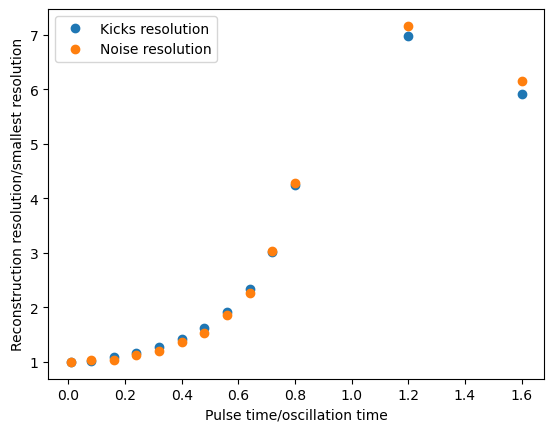

In [354]:
plt.plot((np.array(imp_lens)-1)*10**(-7)*80000, widths/widths[0], 'o', label = 'Kicks resolution')
plt.plot((np.array(imp_lens)-1)*10**(-7)*80000, widths_noise/widths_noise[0], 'o', label = 'Noise resolution')
plt.ylabel('Reconstruction resolution/smallest resolution')
plt.xlabel('Pulse time/oscillation time')
plt.legend()

In [355]:
widths

[0.10143806243093774,
 0.10311816732654323,
 0.11063135072018429,
 0.11870529301523718,
 0.13002134733915374,
 0.14468078337777987,
 0.1639064050712106,
 0.19358287295475096,
 0.2369252215777155,
 0.3065156675991741,
 0.4308263311937617,
 0.7074970548697206,
 0.5994334719581736]

In [356]:
(np.array(imp_lens)-1)*10**(-7)*80000

array([0.008, 0.08 , 0.16 , 0.24 , 0.32 , 0.4  , 0.48 , 0.56 , 0.64 ,
       0.72 , 0.8  , 1.2  , 1.6  ])

In [15]:
print(abs(fit1[2]/fit1[1]))
print(abs(fit3[2]/fit3[1]))

print(abs(fit2[2]/fit1[1]))
print(abs(fit4[2]/fit3[1]))

0.007424101629407216
0.02384506745793934
0.0067194105137588535
0.02125560702763549


In [319]:
5.5*10**(-6)*80000

0.44